In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from functools import partial
from scipy.spatial import cKDTree

import warnings

warnings.filterwarnings('ignore', 'divide by zero')

C:\Users\dayo\py39\envs\izi_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ATMO 5331 - Homework 5 & 6 - Fall 2023
## Due **Thursday** 30 Nov, 2023, 11:59 pm.
## *Worth two assignments*

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

**1.** Copy in your setup from HW3, so that you have the radar data, radar locations, and analysis grid available. Use only the tangent plane cartesian system part, and you don't need to include the plots. Take the time to clean up your original code so that it's the minimally necessary set of variables and functions.

In [3]:
# Read netcdf file
d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')
#d

In [4]:
scan_idx = 1

In [5]:
def coords_2d(d, scan_idx):
    # Obtain the edges of spherical coordinates (range, azimuth, elevation) for a given scan index
    range, azimuth, elevation = spherical_coord_edges(d, scan_idx)
    # Assigning the spherical coordinates to constant variables for clarity
    r_c2e = (range)
    az_c2e = (azimuth)
    ele_c2e = (elevation)
    # Creating a 2D grid for range and azimuth values
    r_2d, az_2d = np.meshgrid(r_c2e, az_c2e)
    # Creating a 2D grid for range and elevation values
    r_2d, el_2d = np.meshgrid(r_c2e, ele_c2e)
    # Returning the 2D grids for range-azimuth and range-elevation
    return r_2d, az_2d, el_2d

def spherical_coord_edges(x, scan_idx):
    # Extract start and end ray indices for the specified scan
    sw_s = x.sweep_start_ray_index[scan_idx].values.item()
    sw_e = x.sweep_end_ray_index[scan_idx].values.item()
    # Extract the range, azimuth, and elevation values for the given scan
    ran = x.range.values
    azi = x.azimuth[sw_s:sw_e].values
    ele = x.elevation[sw_s:sw_e].values
    # Return the range, azimuth, and elevation values
    return ran, azi, ele

# Eric's `centers_to_edges_1d` conversion method
def centers_to_edges_1d(x): 
    nx_edges = x.shape[0] + 1
    xe = np.zeros(nx_edges)    
    xe[1:-1] = (x[1:] + x[:-1]) / 2.0    
    xe[0] = x[0] - (x[1] - x[0]) / 2.0
    xe[-1] = x[-1] + (x[-1] - x[-2]) / 2.0
    # Return the calculated edges
    return xe


In [6]:
from coords import RadarCoordinateSystem

# Retrieving the latitude, longitude, and altitude values from the data
lat = d.latitude
lon = d.longitude
alt = d.altitude

# Calculating the 2D coordinates (range, azimuth, elevation) for a given scan index
r, az, el = coords_2d(d, scan_idx)

# Initializing a radar coordinate system with given latitude, longitude, altitude, and Earth model parameters
rad_cord = RadarCoordinateSystem(lat, lon, alt, datum='WGS84', ellps='WGS84', effectiveRadiusMultiplier=1.3333333333333333)

# Converting spherical coordinates (range, azimuth, elevation) to Earth-Centered, Earth-Fixed (ECEF) coordinates
lon_ecef, lat_ecef, alt_ecef = rad_cord.toECEF(r, az, el)

from coords import TangentPlaneCartesianSystem

# Initializing a tangent plane coordinate system centered at the radar's location
tpcs = TangentPlaneCartesianSystem(lat, lon, alt)
# Converting the ECEF coordinates to tangent plane Cartesian coordinates
X, Y, Z = tpcs.fromECEF(lon_ecef, lat_ecef, alt_ecef)

# Reshaping the Cartesian coordinates to match the shapes of the corresponding spherical coordinates
X.shape = r.shape
Y.shape = az.shape
Z.shape = el.shape

**2.** Configuration of the weighting scheme requires that we know the typical data spacing. Following [TD2000](https://journals.ametsoc.org/view/journals/atot/17/2/1520-0426_2000_017_0105_rdoa_2_0_co_2.xml?tab_body=fulltext-display), define the data spacing as the distance betweent two radar gates at the maximum range. Use the point in your analysis grid that is farthest from the radar, and then find the maximum spacing in elevation angle at this range. Finally, calculate the difference in linear units between the two radar gates you idenified.

Please provide an answer to these two questions:
- What is the maximum distance from the radar in the objective analysis domain?
- What is the maximum spacing between two adjacent data points?

In [7]:
# Calculating ground range (distance in the XY plane) and height (Z coordinate)
grd_r = np.sqrt((X**2 + Y**2))
grd_h = Z

# Ensuring ground range and height arrays have the same shape as the spherical coordinates
grd_r.shape = r.shape
grd_h.shape = az.shape

# Extracting subsets of ground range and height values based on specific criteria
gr_rn_sub = grd_r[(grd_h >= 2900) & (grd_h <= 3400) & (grd_r >= 9000) & (grd_r <= 9500)]
gr_h_sub = grd_h[(grd_h >= 2900) & (grd_h <= 3400) & (grd_r >= 9000) & (grd_r <= 9500)]

# Flattening the arrays for further processing
gr_rn_flt = gr_rn_sub.flatten()
gr_h_flt = gr_h_sub.flatten()

# Calculating the distance (in a 2D plane) for each point in the subset
distance = np.sqrt(gr_rn_flt**2 + gr_h_flt**2)

# Maximum distance from the radar
max_distance = np.amax(distance)

# Print the maximum distance rounded to 3 decimal places
print(f"Maximum distance from the radar: {max_distance:.1f} meters")


Maximum distance from the radar: 10080.6 meters


In [8]:
# Extract elevation angles
# Calculate the differences between consecutive elevation angles
el_diff = np.diff(el, axis=0) 

# Step 3: Find the maximum difference
max_el_diff = np.max(np.abs(el_diff))  

# Print the maximum difference, formatted to three decimal places, with the unit 'degrees'
print(f"Maximum difference in elevation angles: {max_el_diff:.3f} degrees")


Maximum difference in elevation angles: 0.203 degrees


In [9]:
# Calculate the differences in elevation
diff_ele = el[1:] - el[:-1]

# Convert the maximum difference in elevation to radians
max_diff_ele_rad = np.radians(np.amax(diff_ele))

# Calculate the maximum spacing between two adjacent data points
max_distance = np.amax(distance)
max_spacing = max_distance * np.sin(max_diff_ele_rad)/2

print(f"Maximum spacing between two points: {max_spacing:.3f}")

Maximum spacing between two points: 17.880


**3.** Below, the function `oban` (for "objective analysis") mimics the call signature of the MetPy `interpolate_to_points` function. Its principal difference is the `weight_func` argument, which takes a function instead of a string describing an interpolation method. 

The `oban` function passes `weight_func` only the distances, so it is necessary to use `partial` to pre-fill the function with any other arguments needed to configure the weight function. The `sample_weights` function below shows how this works.

For fun, I've also included a seasonal illustration of the use of `partial`.

For this question, your jobs are as follows.

**a.**  Specify a cutoff radius. Based on the last homework assignment, what is a good distance to use as a multiple of the data spacing? Make sure to adjust your set of input data points to include the necessary margin beyond the perimeter of the analysis grid.

**b.**  Implement a `barnes` function and then use it with `oban` to calculate an analysis for reflectivity on the target grid.  Note that you will need to complete the `oban` function in a way that will work with any weight function.

**c.**  Calculate a Barnes analysis using MetPy, as in the last assignment, and find the difference (yours - MetPy). They probably won't be the same, even for a sane configuration of parameters; that's ok.

**d.**  Plot the original data, the two analyses, and the difference.


In [10]:
'''
def oban(points, values, xi, weight_func, search_radius):
    """
    points: N,2 data point locations
    values: N data values
    xi: M,2 analysis locations
    weight_func is a function that accepts a single argument r that is the
        distance between the analysis location and all points within search_radius
        of the analysis location.
    """
    
    # Find all points in the vicinity of each analysis location in xi
    tree = cKDTree(points)
    query = tree.query_ball_point(xi, search_radius)
    
    analysis = np.zeros(xi.shape[0])
    
    # This is linear (times the typical neighborhood size) in the number of analysis points
    for i, (analysis_point, neighbors) in enumerate(zip(xi, query)):
        data = values[neighbors]
        data_locations = points[neighbors,:]
        # use data, data_locations, analysis_point, and weight_func to fill in the rest of the analysis
        analysis[i] = None # your code here
    return analysis

def sample_weights(r, value=None):
    return np.zeros_like(r) + value

my_weight_func = partial(sample_weights, value=3.0)
my_test_ranges = np.arange(10.0)
my_test_weights = my_weight_func(my_test_ranges) # oban will call my_weight_func like so
print(my_test_weights) 
'''

'\ndef oban(points, values, xi, weight_func, search_radius):\n    """\n    points: N,2 data point locations\n    values: N data values\n    xi: M,2 analysis locations\n    weight_func is a function that accepts a single argument r that is the\n        distance between the analysis location and all points within search_radius\n        of the analysis location.\n    """\n    \n    # Find all points in the vicinity of each analysis location in xi\n    tree = cKDTree(points)\n    query = tree.query_ball_point(xi, search_radius)\n    \n    analysis = np.zeros(xi.shape[0])\n    \n    # This is linear (times the typical neighborhood size) in the number of analysis points\n    for i, (analysis_point, neighbors) in enumerate(zip(xi, query)):\n        data = values[neighbors]\n        data_locations = points[neighbors,:]\n        # use data, data_locations, analysis_point, and weight_func to fill in the rest of the analysis\n        analysis[i] = None # your code here\n    return analysis\n\ndef

### Answer to 3 (a & b)

In [11]:
# Given values for the construction of grid and radar data
x_start, x_end = 9000, 9500  # in meters
y_start, y_end = 2900, 3400  # in meters
fine_spacing = 5  # 5 meters

# Extended drid
x_start_ext = x_start - fine_spacing
x_end_ext = x_end + fine_spacing
y_start_ext = y_start - fine_spacing
y_end_ext = y_end + fine_spacing

# Recompute the edges with the extended range
x_edges_ext = np.arange(x_start_ext, x_end_ext + fine_spacing, fine_spacing)
y_edges_ext = np.arange(y_start_ext, y_end_ext + fine_spacing, fine_spacing)

# Determine the center locations with the extended range
x_centers = (x_edges_ext[1:] + x_edges_ext[:-1]) / 2.0
y_centers = (y_edges_ext[1:] + y_edges_ext[:-1]) / 2.0

# Use meshgrid to create 2D arrays of center locations
X_centers_grid, Y_centers_grid = np.meshgrid(x_centers, y_centers)


# Recalling start and end indexes
start_idx = d.sweep_start_ray_index[scan_idx].values.item()
end_idx = d.sweep_end_ray_index[scan_idx].values.item()

# Variable of interest
ref = d.reflectivity[:][start_idx:end_idx].values

# Extracting elevation and range for RHI scan mode
elev_ref = d.elevation[start_idx:end_idx].values
range_ref = d.range.values

# Convert spherical coordinates to Cartesian coordinates for the reflectivity data
z_ref = range_ref * np.sin(np.deg2rad(elev_ref[:, np.newaxis]))  # Vertical height
x_ref = range_ref * np.cos(np.deg2rad(elev_ref[:, np.newaxis]))  # Horizontal distance

# Stack the x and z data locations
data_points_ref = np.vstack((x_ref.ravel(), z_ref.ravel())).T
data_values_ref = np.random.rand(*x_ref.shape).ravel()


# Now we have our points (data_points_ref) and values (data_values_ref)
# xi is the grid points where we want to interpolate our data
xi = np.vstack((X_centers_grid.ravel(), Y_centers_grid.ravel())).T

analysis_points_ref = xi

mask_ref = ((data_points_ref[:, 0] >= x_start) & (data_points_ref[:, 0] <= x_end) &
            (data_points_ref[:, 1] >= y_start) & (data_points_ref[:, 1] <= y_end))

subset_points_ref = data_points_ref[mask_ref]
subset_values_ref = data_values_ref[mask_ref]


points = subset_points_ref
values = subset_values_ref

# Define the weight function using Barnes' method
def weight_func(distances, kappa=0.5):
    weights = np.exp(-distances**2 / kappa)
    weights[weights < 0.1] = 0  # set cut off
    return weights

# Define a search radius for the oban function
search_radius=3*max_spacing

# Implement the oban function
def oban(points, values, xi, weight_func, search_radius):
    tree = cKDTree(points)
    query = tree.query_ball_point(xi, search_radius)
    
    analysis = np.zeros(xi.shape[0])
    
    for i, (analysis_point, neighbors) in enumerate(zip(xi, query)):
        if not neighbors:  # Check if the list of neighbors is empty
            analysis[i] = np.nan
            continue

        data = values[neighbors]
        data_locations = points[neighbors,:]
        
        distances = np.linalg.norm(data_locations - analysis_point, axis=1)
        weights = weight_func(distances)
        
        if np.sum(weights) > 0:
            analysis[i] = np.sum(data * weights) / np.sum(weights)
        else:
            analysis[i] = np.nan
        
    return analysis

# Running the oban function with the extracted data
result_barn = oban(subset_points_ref, subset_values_ref, analysis_points_ref, weight_func, search_radius)

# Reshaping the result back into the shape of the grid for visualization
result_barn_reshaped = result_barn.reshape(X_centers_grid.shape)

### Answer to 3 (c)

In [12]:
# Import useful intepolation functions from metpy library
from metpy.interpolate import interpolate_to_points

# Perform Barnes Analysis (Gaussian blur) using MetPy
barnes_interp_ref = interpolate_to_points(subset_points_ref, subset_values_ref, analysis_points_ref, interp_type='barnes').reshape(X_centers_grid.shape)

# Find the difference between the two analyses (B_OBAN - B_Metpy)
analysis_difference = result_barn_reshaped - barnes_interp_ref

analysis_difference.shape  # This should match the shape of X_centers_grid and Y_centers_grid

(102, 102)

### Answer to 3 (d)

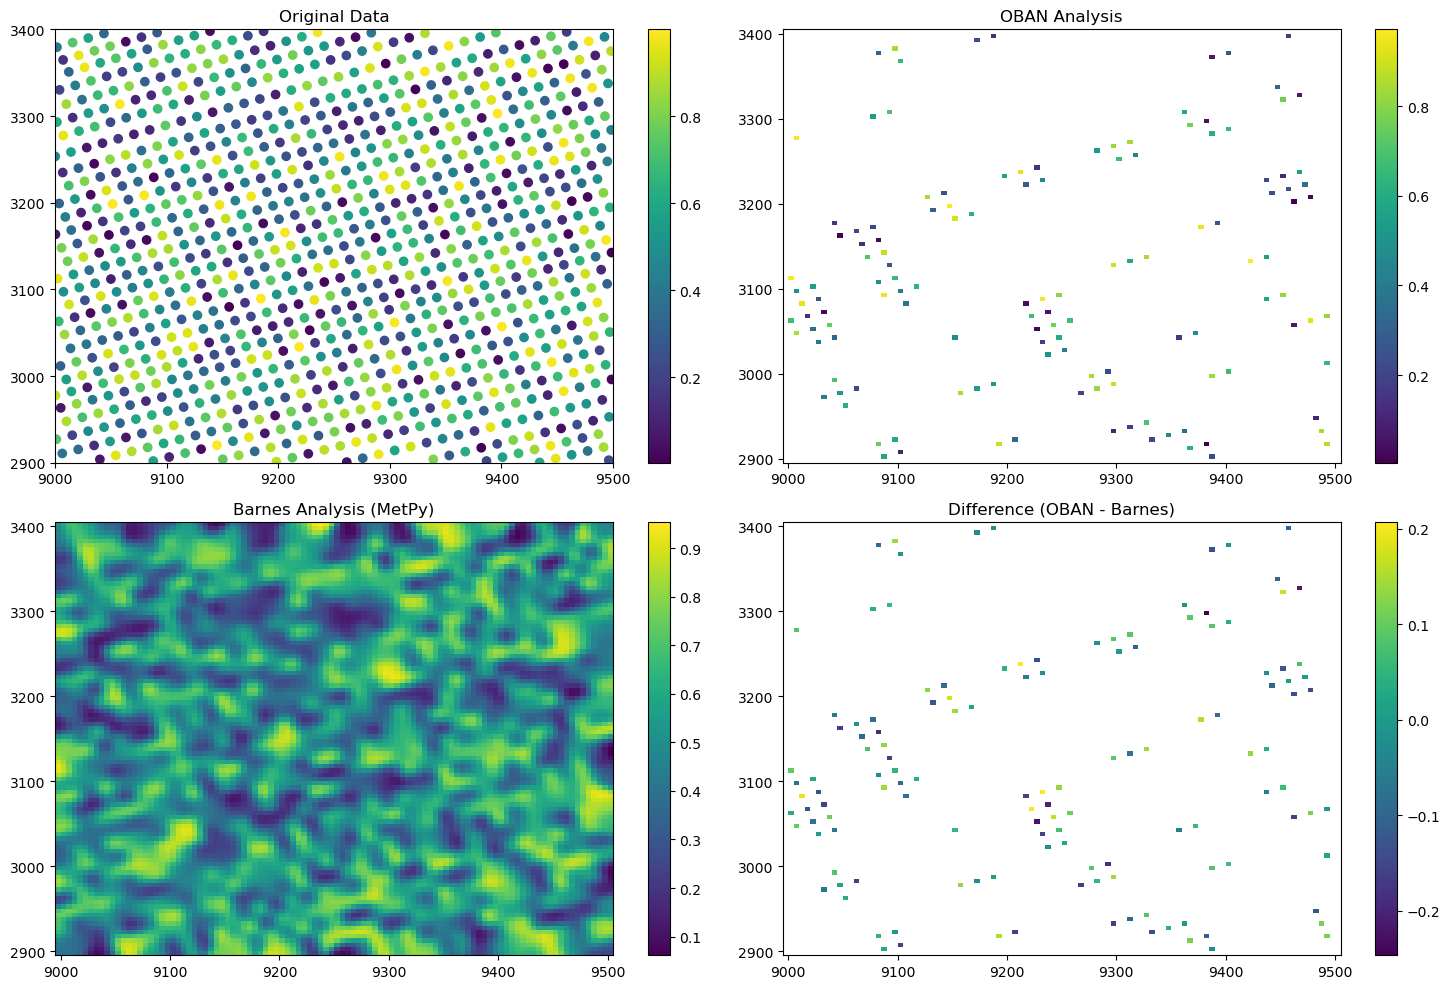

In [13]:
# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Original data
sc = axs[0, 0].scatter(subset_points_ref[:, 0], subset_points_ref[:, 1], c=subset_values_ref)
plt.colorbar(sc, ax=axs[0, 0])
axs[0, 0].set_title('Original Data')
axs[0, 0].set_xlim([x_start, x_end])
axs[0, 0].set_ylim([y_start, y_end])

# oban analysis
pcm = axs[0, 1].pcolormesh(X_centers_grid, Y_centers_grid, result_barn_reshaped, shading='auto')
plt.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].set_title('OBAN Analysis')

# Barnes analysis from MetPy
pcm = axs[1, 0].pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_ref, shading='auto')
plt.colorbar(pcm, ax=axs[1, 0])
axs[1, 0].set_title('Barnes Analysis (MetPy)')

# Difference
pcm = axs[1, 1].pcolormesh(X_centers_grid, Y_centers_grid, analysis_difference, shading='auto')
plt.colorbar(pcm, ax=axs[1, 1])
axs[1, 1].set_title('Difference (OBAN - Barnes)')

# Set tight layout to minimize wasted space
plt.tight_layout()
plt.show()


**4.** Let's say we want to use another filter from [Harris (1978)](https://ieeexplore.ieee.org/iel5/5/31261/01455106.pdf?casa_token=nY_Vus-tiGQAAAAA:1K1Z17V0-r1wCpI7TlY0OFKZGTTtigj1xTtyLAj_DEkaAVYnkDVUh7Kl0BLFJjQZ4647zYZJm4c-) for our continuous data. Those functions are specified for discrete data, with a hard cutoff after $N$ samples. It would be logical to cut off all our analyses after the same cutoff radius for all data, so that our understanding of the filter function sidelobe behavior from discrete theory can be applied to continous data in an even-handed way.

So, let's repeat the previous question, but now using the Rectangular and Blackman-Harris weights. You will need to use Harris (1978) for the mathematical formulation of the windows, as defined below.

**a.**  Implement a `rect` function and then use it with `oban` to calculate an analysis on the target grid.

**b.**  Implement a `blackman_harris` function and then use it with `oban` to calculate an analysis on the target grid. Use the minimum 4-term Blackman-Harris formulation as in the `scipy.signal.blackmanharris` docs whose coefficients are the -92 dB 4-term window in the table on p. 65 of Harris.

**c.**  Include in this notebook, using a Markdown cell and the $\LaTeX$ functionality, a narrated derivation that shows how you converted the discrete, non-dimensional formulation of the Blackman-Harris weight function to a continuous, dimensional form.

**d.**  Make a plot of the weight functions as a function of distance from zero to your cutoff radius.

**e.**  Plot the original data and the two analyses.



### 4 (a)

In [14]:
# Rectangular function
def rect(r):
    # Create a weight array of ones 
    weights = np.ones_like(r)
    # Set weights to zero 
    weights[r > search_radius] = 0
    return weights

# The oban function for spatial analysis using the rectangular weights
def oban(points, values, xi, weight_func, search_radius):
    # Build a KDTree for efficient neighbor searches
    tree = cKDTree(points)
    analysis = np.zeros(xi.shape[0])
    
    for i, analysis_point in enumerate(xi):
        # Find indices of points within the search_radius
        indices = tree.query_ball_point(analysis_point, search_radius)
        # Find the locations of these points
        data_locations = points[indices]
        # Calculate distances from the analysis point to these data locations
        r = np.linalg.norm(data_locations - analysis_point, axis=1)
        # Pass these distances to the weight function
        weights = weight_func(r)
        
        # Apply weights to the corresponding values
        if np.sum(weights) > 0:
            analysis[i] = np.sum(weights * values[indices]) / np.sum(weights)
        else:
            analysis[i] = np.nan  # Assign NaN if there are no points within the search radius
    
    return analysis

# Run the oban function with the rectangular weights
result_rect = oban(subset_points_ref, subset_values_ref, analysis_points_ref, rect, search_radius)

# Reshape the result back into the shape of the grid for visualization
result_rect_reshaped = result_rect.reshape(X_centers_grid.shape)


### 4 (b)

In [15]:
# Blackman-Harris function
def blackman_harris(r):
    a0 = 0.35875
    a1 = 0.48829
    a2 = 0.14128
    a3 = 0.01168
    N = 2 * search_radius  # Use search_radius from the outer scope

    weights = (a0
               - a1 * np.cos((2 * np.pi / N) * (r + (N / 2)))
               + a2 * np.cos((4 * np.pi / N) * (r + (N / 2)))
               - a3 * np.cos((6 * np.pi / N) * (r + (N / 2))))

    # Normalize the weights
    weights /= np.sum(weights)
    
    # Set weights to zero outside the search radius
    weights[r > search_radius] = 0
    return weights

# The oban function for spatial analysis using the Blackman-Harris weights
def oban(points, values, xi, weight_func, search_radius):
    # Build a KDTree for efficient neighbor searches
    tree = cKDTree(points)
    analysis = np.zeros(xi.shape[0])
    
    for i, analysis_point in enumerate(xi):
        # Find indices of points within the search_radius
        indices = tree.query_ball_point(analysis_point, search_radius)
        # Find the locations of these points
        data_locations = points[indices]
        # Calculate distances from the analysis point to these data locations
        r = np.linalg.norm(data_locations - analysis_point, axis=1)
        # Pass these distances to the weight function
        weights = weight_func(r)
        
        # Apply weights to the corresponding values
        if np.sum(weights) > 0:
            analysis[i] = np.sum(weights * values[indices]) / np.sum(weights)
        else:
            analysis[i] = np.nan  # Assign NaN if there are no points within the search radius
    
    return analysis

# Run the oban function with the Blackman-Harris weights
result_bh = oban(subset_points_ref, subset_values_ref, analysis_points_ref, blackman_harris, search_radius)

# Reshape the result back into the shape of the grid for visualization
result_bh_reshaped = result_bh.reshape(X_centers_grid.shape)

### 4 (c)

### Derivation of the Blackman-Harris Weight Function

The discrete, non-dimensional form of the Blackman-Harris weight function is given by:

$$
w[n] = a_0 - a_1 \cos\left(\frac{2\pi n}{N}\right) + a_2 \cos\left(\frac{4\pi n}{N}\right) - a_3 \cos\left(\frac{6\pi n}{N}\right)
$$

where $n$ is the discrete index, $N$ is the length of the window, and $a_0$, $a_1$, $a_2$, $a_3$ are the specific coefficients of the Blackman-Harris window.

To convert this to a continuous form, one consider a continuous variable $r$ which represents the distance from the analysis point in a continuous space and replace the discrete index $n$ with a continuous variable $r$. The length of the window $N$ becomes the window's width in terms of the physical distance, which is $2 \times \text{search_radius}$ in our continuous domain.

Thus, the continuous, dimensional form of the Blackman-Harris weight function becomes:

$$
w(r) = a_0 - a_1 \cos\left(\frac{2\pi (r + \text{search_radius})}{2 \times \text{search_radius}}\right) + a_2 \cos\left(\frac{4\pi (r + \text{search_radius})}{2 \times \text{search_radius}}\right) - a_3 \cos\left(\frac{6\pi (r + \text{search_radius})}{2 \times \text{search_radius}}\right)
$$

Here, I have shifted the cosine terms by adding $\text{search_radius}$ to $r$ so that the window is centered at $r = 0$, and the function spans from $-\text{search_radius}$ to $+\text{search_radius}$.

To ensure that the weights sum up to 1, I normalize the function by dividing by the sum of the weights over the entire range:

$$
w(r) = \frac{w(r)}{\int_{-\text{search_radius}}^{\text{search_radius}} w(r) \, dr}
$$

This normalization ensures that the integral of the weight function over the window's width equals one, thereby preserving the total energy of the signal when the weights are applied.


#### (d)

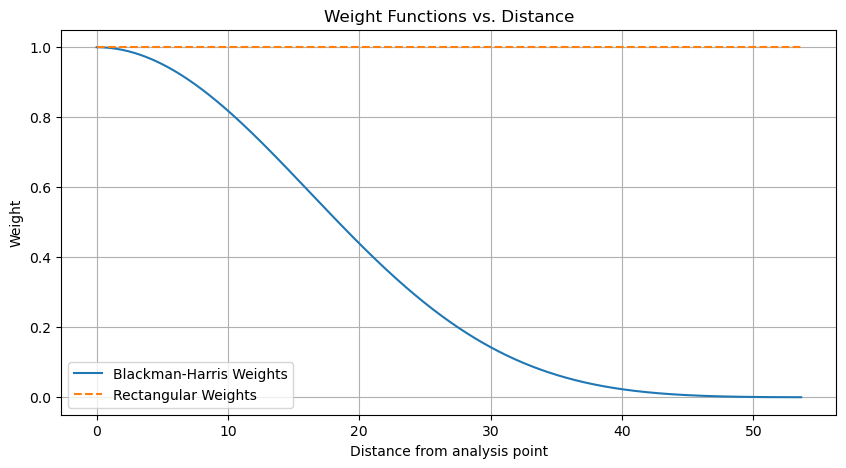

In [16]:
# Blackman-Harris function
def blackman_harris(r):
    # Use search_radius from the outer scope
    a0 = 0.35875
    a1 = 0.48829
    a2 = 0.14128
    a3 = 0.01168
    N = 2 * search_radius
    weights = (a0
               - a1 * np.cos((2 * np.pi / N) * (r + (N / 2)))
               + a2 * np.cos((4 * np.pi / N) * (r + (N / 2)))
               - a3 * np.cos((6 * np.pi / N) * (r + (N / 2))))
    weights[r > search_radius] = 0
    return weights

# Rectangular function
def rect(r):
    # Use search_radius from the outer scope
    weights = np.ones_like(r)
    weights[r > search_radius] = 0
    return weights

# Create a range of distances
r = np.linspace(0, search_radius, 1000)  # Distances from 0 to cutoff radius

# Calculate the weights for both functions
weights_bh = blackman_harris(r)
weights_rect = rect(r)

# Plot the weight functions
plt.figure(figsize=(10, 5))
plt.plot(r, weights_bh, label='Blackman-Harris Weights')
plt.plot(r, weights_rect, label='Rectangular Weights', linestyle='--')
plt.xlabel('Distance from analysis point')
plt.ylabel('Weight')
plt.title('Weight Functions vs. Distance')
plt.legend()
plt.grid(True)
plt.show()


### 4 (e)

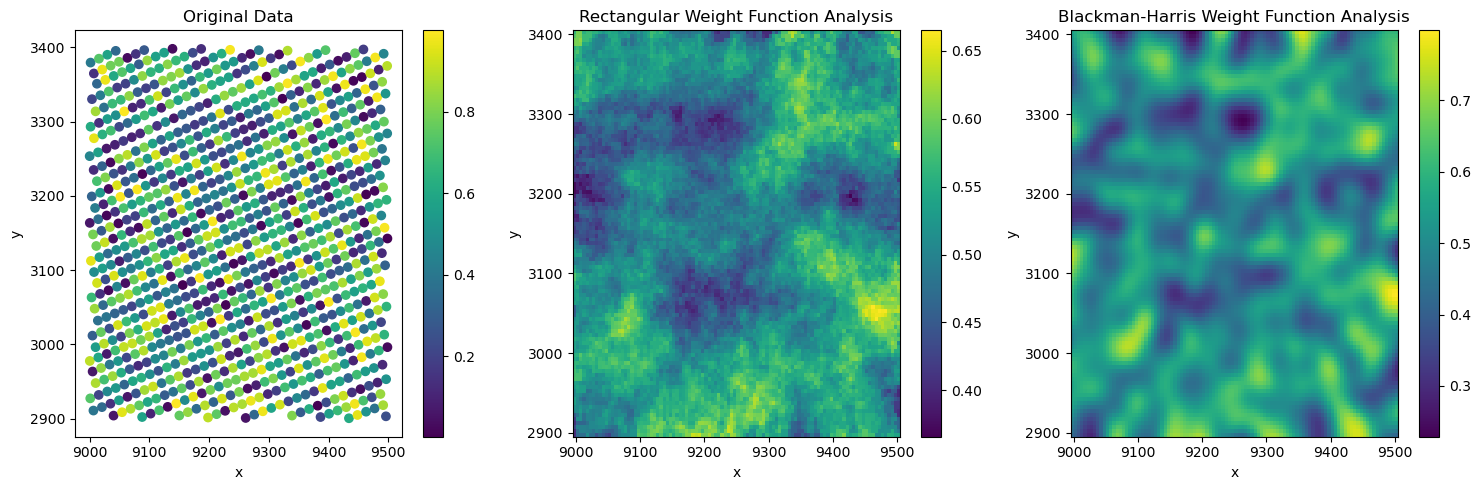

In [17]:
# Original data plot
plt.figure(figsize=(15, 5))

# Original Data
plt.subplot(1, 3, 1)
plt.scatter(subset_points_ref[:, 0], subset_points_ref[:, 1], c=subset_values_ref)
plt.colorbar()
plt.title('Original Data')
plt.xlabel('x')
plt.ylabel('y')

# Rectangular Weight Function Analysis
plt.subplot(1, 3, 2)
plt.pcolormesh(X_centers_grid, Y_centers_grid, result_rect_reshaped, shading='auto')
plt.colorbar()
plt.title('Rectangular Weight Function Analysis')
plt.xlabel('x')
plt.ylabel('y')

# Blackman-Harris Weight Function Analysis
plt.subplot(1, 3, 3)
plt.pcolormesh(X_centers_grid, Y_centers_grid, result_bh_reshaped, shading='auto')
plt.colorbar()
plt.title('Blackman-Harris Weight Function Analysis')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()



**5.** Let's compare the different filters.

**a.** Plot the original data, and using the Barnes filter as a common point of comparison, plot the difference with the other two analyses you calculated.

**b.** Which weighting scheme preserves the greatest detail in fine-scale structure? Illustrate this by discussing a local minimum and a local maximum in the original data vs. the difference fields. Does it make sense in terms of the theoretical response functions we calcualted in the previous homework?

### 5 (a)

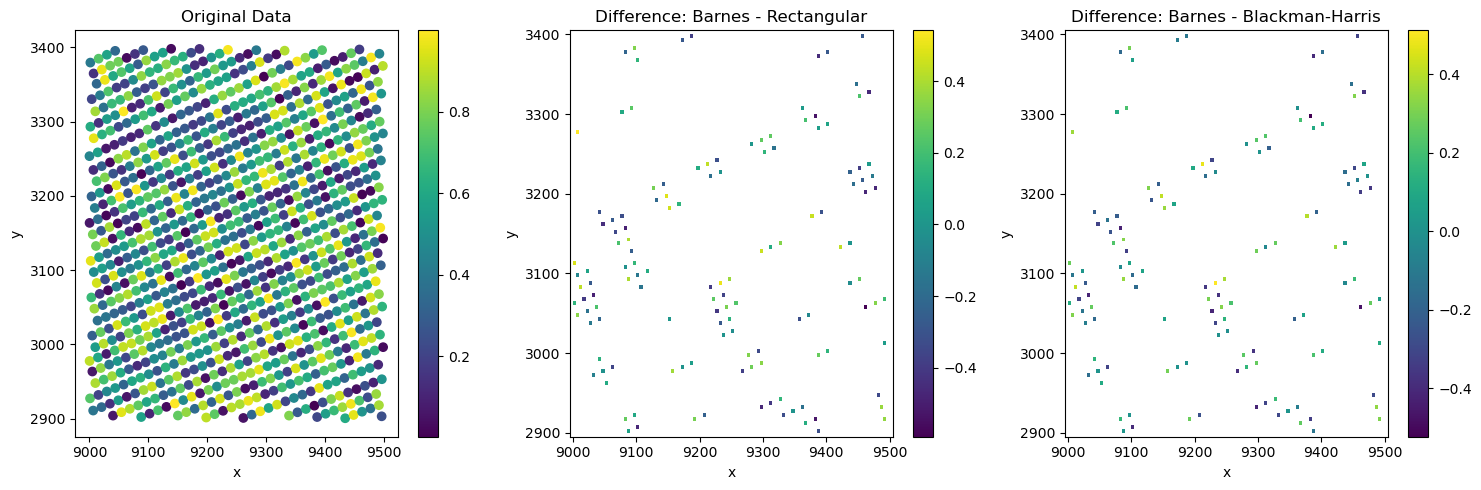

In [18]:
# Calculate the differences
difference_rect_barnes = result_barn_reshaped - result_rect_reshaped
difference_bh_barnes = result_barn_reshaped - result_bh_reshaped

# Plot the original data and the differences
plt.figure(figsize=(15, 5))

# Original Data
plt.subplot(1, 3, 1)
plt.scatter(subset_points_ref[:, 0], subset_points_ref[:, 1], c=subset_values_ref)
plt.colorbar()
plt.title('Original Data')
plt.xlabel('x')
plt.ylabel('y')

# Difference: Barnes - Rectangular
plt.subplot(1, 3, 2)
plt.pcolormesh(X_centers_grid, Y_centers_grid, difference_rect_barnes, shading='auto')
plt.colorbar()
plt.title('Difference: Barnes - Rectangular')
plt.xlabel('x')
plt.ylabel('y')

# Difference: Barnes - Blackman-Harris
plt.subplot(1, 3, 3)
plt.pcolormesh(X_centers_grid, Y_centers_grid, difference_bh_barnes, shading='auto')
plt.colorbar()
plt.title('Difference: Barnes - Blackman-Harris')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


### 5b(i)
- Which weighting scheme preserves the greatest detail in fine-scale structure?

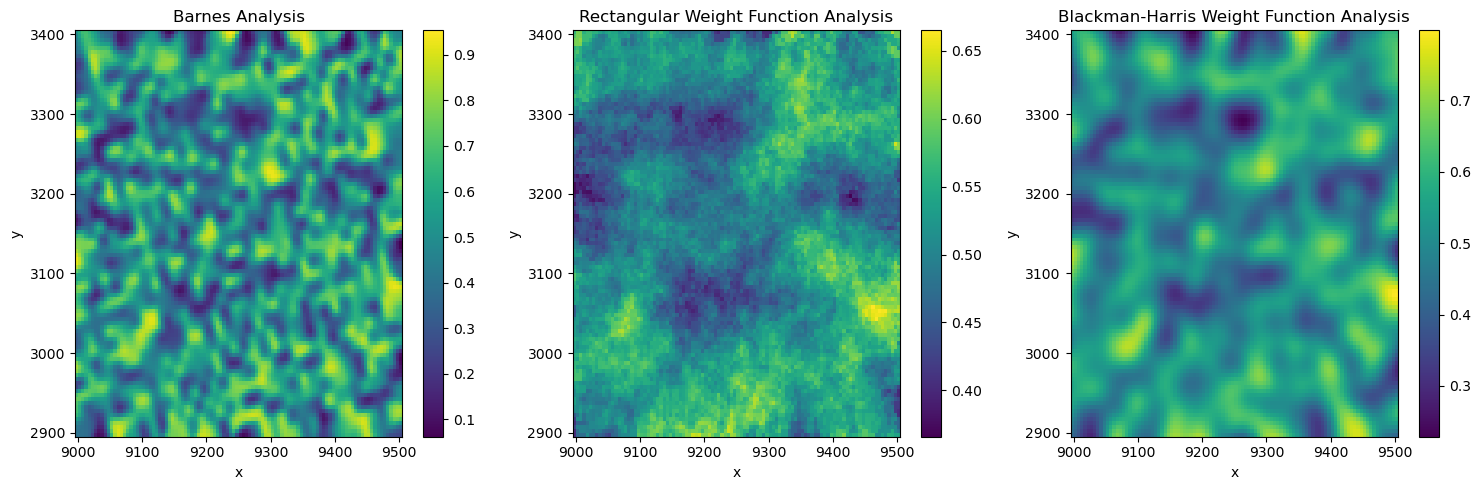

In [19]:
# Plot the original data and the differences
plt.figure(figsize=(15, 5))

# Original Data
plt.subplot(1, 3, 1)
# Barnes analysis
plt.pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_ref, shading='auto')
plt.colorbar()
plt.title('Barnes Analysis')
plt.xlabel('x')
plt.ylabel('y')


# Rectangular Weight Function Analysis
plt.subplot(1, 3, 2)
plt.pcolormesh(X_centers_grid, Y_centers_grid, result_rect_reshaped, shading='auto')
plt.colorbar()
plt.title('Rectangular Weight Function Analysis')
plt.xlabel('x')
plt.ylabel('y')

# Blackman-Harris Weight Function Analysis
plt.subplot(1, 3, 3)
plt.pcolormesh(X_centers_grid, Y_centers_grid, result_bh_reshaped, shading='auto')
plt.colorbar()
plt.title('Blackman-Harris Weight Function Analysis')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()




#### Answer
Based on the visual comparison of the three panels, the Blackman-Harris Weight Function Analysis seems to show more distinct variations and sharper transitions between different data levels, suggesting that it preserves more of the fine-scale structure compared to the other two methods. The Barnes Analysis appears smoother than the Blackman-Harris, and the Rectangular Weight Function Analysis appears to be the smoothest, indicating that it preserves the least detail in fine-scale structure.

#### Context
- Barnes Analysis typically uses a Gaussian or similar weight function, which smooths data but can also preserve peaks and troughs to a certain extent, depending on the chosen scale and decay parameters.

- Rectangular Weight Function Analysis uses a uniform weight, which means it considers all points within a certain range equally. This can lead to a loss of fine-scale structure since it does not differentiate between close and far points within the weight function's range.

- Blackman-Harris Weight Function Analysis applies a specific window function that is designed to reduce spectral leakage. This can result in a better preservation of fine-scale features compared to a simple rectangular function because it weights the data in a way that decreases the side-lobes in the frequency domain representation of the signal.

### 5b(ii)
- Illustrate this by discussing a local minimum and a local maximum in the original data vs. the difference fields?

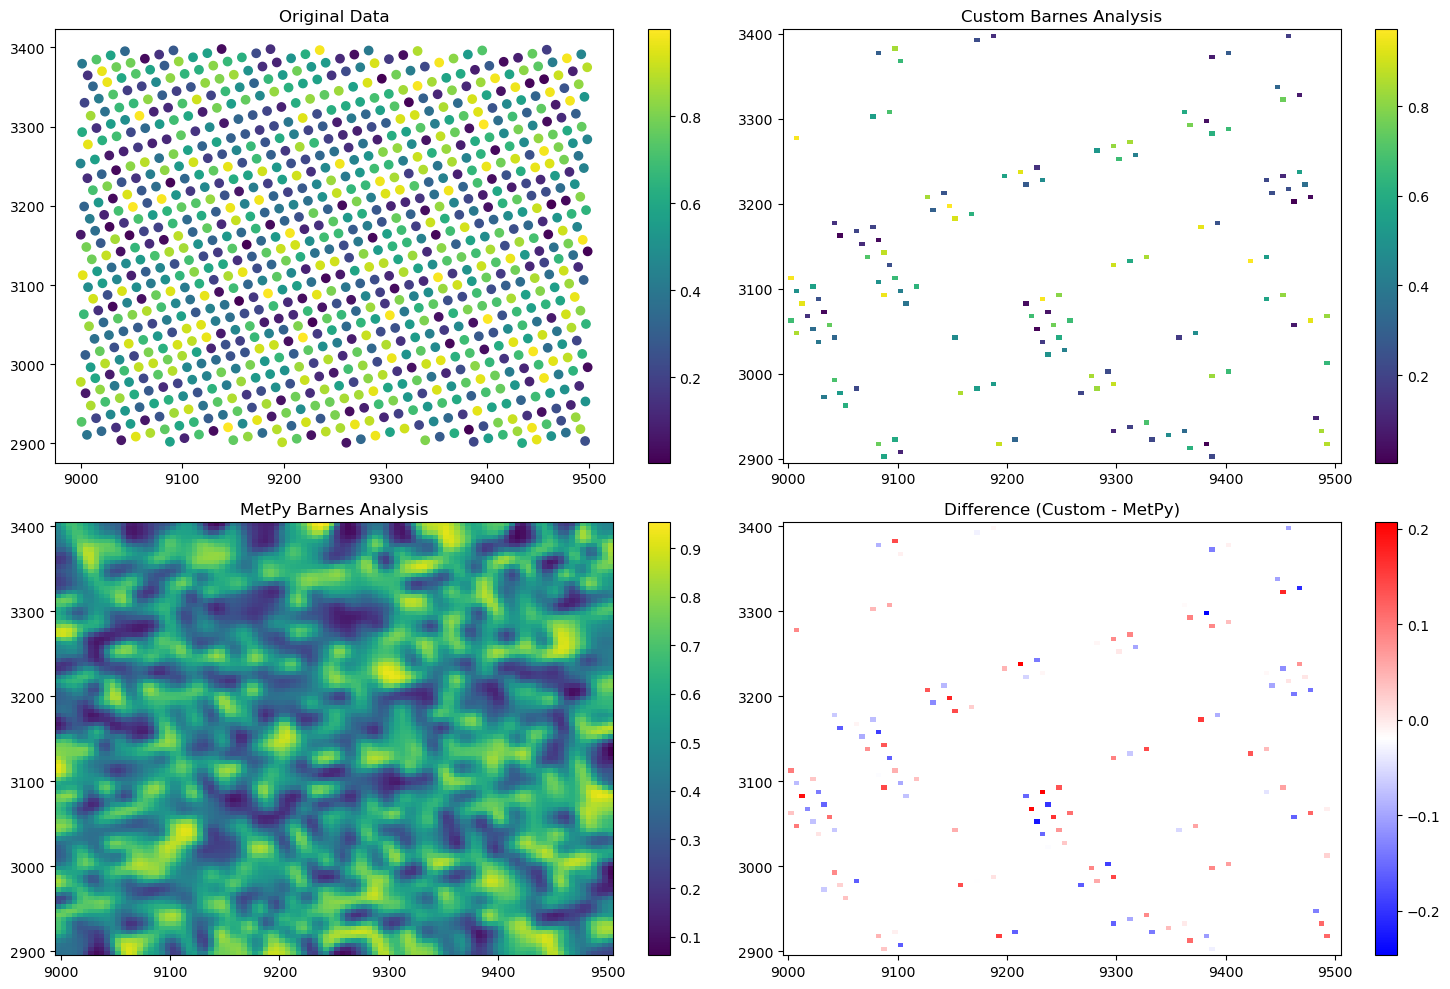

In [20]:
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Original data
sc = axs[0, 0].scatter(subset_points_ref[:, 0], subset_points_ref[:, 1], c=subset_values_ref, cmap='viridis')
plt.colorbar(sc, ax=axs[0, 0])
axs[0, 0].set_title('Original Data')

# Custom Barnes analysis
pcm = axs[0, 1].pcolormesh(X_centers_grid, Y_centers_grid, result_barn_reshaped, shading='auto')
plt.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].set_title('Custom Barnes Analysis')

# MetPy Barnes analysis
pcm = axs[1, 0].pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_ref, shading='auto')
plt.colorbar(pcm, ax=axs[1, 0])
axs[1, 0].set_title('MetPy Barnes Analysis')

# Difference between Custom and MetPy Barnes analyses
pcm = axs[1, 1].pcolormesh(X_centers_grid, Y_centers_grid, analysis_difference, shading='auto', cmap='bwr')
plt.colorbar(pcm, ax=axs[1, 1])
axs[1, 1].set_title('Difference (Custom - MetPy)')

plt.tight_layout()
plt.show()

#### Answer
- In the difference plot, a large negative value (dark blue) suggests a peak in the MetPy analysis that the custom analysis did not capture, indicating that the MetPy method may better preserve a local maximum. A large positive value (dark red) suggests a trough in the custom analysis that the MetPy did not capture as deeply, indicating that the custom method might be accentuating a local minimum.

#### Context
- By comparing these areas to the original data plot, one can verify whether these differences align with actual local maxima and minima in the original dataset. Basically, a dark blue spot on the `difference plot` corresponds to a point on the `original data plot` that is indeed surrounded by lower values, this confirms that the MetPy analysis has preserved a local maximum that the custom analysis missed. The opposite scenario occurs for a dark red spot suggesting a local minimum when superimposed on the `original data plot`.

Similar ideology goes for the Rectangular and Blackman Harris (differences) plotted in 5(a)

#### Does it make sense in terms of the theoretical response functions we calcualted in the previous homework?

- Although this is a rhetorical question, I feel it does make sense, in my opinion